In [1]:
from __future__ import division, print_function, absolute_import

import os
from timeit import time
import warnings
import sys
import cv2 as cv
import numpy as np
from PIL import Image
from yolo import YOLO
from matplotlib import pyplot as plt
import json
import pdb

from deep_sort import preprocessing
from deep_sort import nn_matching
from deep_sort.detection import Detection
from deep_sort.tracker import Tracker
from tools import generate_detections as gdet
from deep_sort.detection import Detection as ddet

%matplotlib inline
warnings.filterwarnings('ignore')

/Users/mengwan/anaconda/envs/SSD/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
cam_id = 'AB16'
start_time = 0

In [20]:
# Definition of the parameters
max_cosine_distance = 0.3
nn_budget = None
nms_max_overlap = 1.0

# deep_sort 
model_filename = 'model_data/mars-small128.pb'
encoder = gdet.create_box_encoder(model_filename,batch_size=1)

metric = nn_matching.NearestNeighborDistanceMetric("cosine", max_cosine_distance, nn_budget)
tracker = Tracker(metric)

In [4]:
yolo = YOLO()

model_data/yolo.h5 model, anchors, and classes loaded.


In [18]:
outputing_video = True 

cap_name = './CAG/morning 0830/AB16-0830H (1).avi'
#cap_name = './CAG/afternoon 1300/AB03-1300H.avi'
#cap_name = './CAG/morning 0830/AB07-0830H (1).avi'
#cap_name = './CAG/afternoon 1300/AB04-1300H.avi'
#cap_name = './CAG/midnight 0200/AB07-0200H.avi'
#cap_name = './CAG/rainy conditions/AB07-1600H.avi'

vcap = cv.VideoCapture(cap_name)
#vcap = cv.VideoCapture('./CAG/afternoon 1300/AB04-1300H.avi')
#vcap = cv.VideoCapture('./CAG/midnight 0200/AB07-0200H.avi')
#vcap = cv.VideoCapture('./CAG/rainy conditions/AB07-1600H.avi')

img_w = int(vcap.get(3))
img_h = int(vcap.get(4))
fps = vcap.get(cv.CAP_PROP_FPS)
fourcc = cv.VideoWriter_fourcc(*'MP4V')
out = cv.VideoWriter('output.mp4', fourcc, fps, (img_w, img_h))

# lane area extremes
#roi = [[0, 365], [0, 575], [767, 575], [767, 498], [438, 170], [241, 170], [0, 365]] # afternoon/AB03-1300H
#roi = [[200, 575], [130, 80], [260, 80], [767, 400], [767, 575], [200, 575]] # morning/AB07-1600H
#roi = [[0, 400], [0, 575], [767, 575], [470, 130], [320, 130], [0, 400]] # afternoon/AB04-1300H
#roi = [[200, 575], [130, 80], [260, 80], [767, 400], [767, 575], [200, 575]] # rainy/AB07-1600H
#roi = [[250, 575], [767, 575], [767, 390], [260, 110], [160, 110], [250, 575]] # night/AB07-0200H

# lane sections info
#sec_length = 4.4 * 3 # in metres (avg car len 4.4 * numbers of cars can fit into section) # afternoon/AB03-1300H
#sections = [575, 352, 268, 225, 170] # afternoon/AB03-1300H

cam_lane_info = {
    'AB03': {'roi': [[0, 365], [0, 575], [767, 575], [767, 498], [438, 170], [241, 170], [0, 365]],
             'sec_length': 4.4 * 3,
             'sections': [575, 352, 268, 225, 170],
             'speed_frames': 5},
    'AB16': {'roi': [[192, 719], [629, 500], [939, 500], [821, 719], [192, 719]],
             'sec_length': 5,
             'sections': [719, 638, 578, 522, 489],
             'speed_frames': 5}
}

roi = cam_lane_info[cam_id]['roi']
sec_length = cam_lane_info[cam_id]['sec_length']
sections = cam_lane_info[cam_id]['sections']

In [6]:
track_encoder = lambda track: {"vechicle_id": track.track_id,
                               "classs": int(track.detection.cls),
                               "conf": track.detection.score,
                               #"speed": track.speed if hasattr(track, 'speed') else 0,
                               "xmin": track.to_tlwh().tolist()[0],
                               "ymin": track.to_tlwh().tolist()[1],
                               "xmax": track.to_tlwh().tolist()[0] + track.to_tlwh().tolist()[2],
                               "ymax": track.to_tlwh().tolist()[1] + track.to_tlwh().tolist()[3]}

jfile = 'output.json'
samples_per_sec = 4 # no. of outputs per second

In [7]:
def _add_cv_drawing(frame, detections, tracker, avg_spd, occupancy):
    for track in tracker.tracks:
        if track.is_confirmed() and track.time_since_update > 1 :
            continue
        bbox = track.to_tlbr()
        cv.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])),(255,255,255), 1)
        cv.putText(frame, str(track.track_id),(int(bbox[0]), int(bbox[1])-3),0, 5e-3 * 100, (0,255,0), 1)
        
    for det in detections:
        bbox = det.to_tlbr()
        cv.rectangle(frame,(int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])),(255,0,0), 1)
        cv.putText(frame, 
                   ' ' + yolo.class_names[det.cls] + ' ' + str(det.score),
                   (int(bbox[0])+3, int(bbox[1])-3), 0, 5e-3 * 100, (0,255,0),1)
    
    cv.putText(frame, 'detections: %d' % len(detections), (5, img_h-48), 0, 5e-3 * 150, (0,255,0), 1)
    cv.putText(frame, 'avergate speed: %.2f' % avg_spd, (5, img_h-28), 0, 5e-3 * 150, (0,255,0), 1)
    cv.putText(frame, 'occupancy: %.2f' % occupancy, (5, img_h-8), 0, 5e-3 * 150, (0,255,0), 1)

In [8]:
def _calc_dist_travelled(ends):
    y1, y2 = ends
    dist = 0
    for idx, s in enumerate(sections[:-1]):
        if idx == 0:
            continue

        if y1 >= s:
            dist += (y1 - s) / (sections[idx - 1] - s) * sec_length
            #print('y1: {} {} {} {}'.format(y1, s, (y1 - s) / (sections[idx - 1] - s) * sec_length, dist))
            y1 = s
            
        if s >= y2 >= sections[idx + 1]:
            dist += (y1 - y2) / (s - sections[idx + 1]) * sec_length
            #print('y2: {} {} {} {}'.format(y2, s, (y1 - y2) / (s - sections[idx + 1]) * sec_length, dist))
            break
            
    return abs(dist)

In [9]:
def _average_track_speed(tracker, fps, frame_idx):
    for track in tracker.tracks:
        if track.is_confirmed() and track.time_since_update > 1 :
            if hasattr(track, 'speed'):
                delattr(track, 'speed')
            continue
            
        # update track speed in y direction, in pixels/seconds
        if not hasattr(track, 'hist_frames'):
            track.hist_frames = []
            track.hist_bboxes = []
        track.hist_frames.append(frame_idx)
        track.hist_bboxes.append(track.to_tlwh())

        if len(track.hist_frames) > speed_frames:
            cur_bbox = track.to_tlwh()
            cur_c_y = (cur_bbox[1] + cur_bbox[3] /2)
            first_bbox = track.hist_bboxes[-speed_frames]
            first_c_y = first_bbox[1] + first_bbox[3] /2
            track.ends = (first_c_y, cur_c_y)

            dist_travelled = _calc_dist_travelled(track.ends)
            life = frame_idx - track.hist_frames[-speed_frames]
            speed = dist_travelled / life * fps * 3.6 # km/hr
            
            track.speed = speed
            #pdb.set_trace()
    
    track_speeds = [track.speed for track in tracker.tracks if hasattr(track, 'speed')]
    avg_spd = np.sum(track_speeds) / len(track_speeds)
    
    return avg_spd

In [ ]:
def _calc_LOS(occupancy, avg_spd):
    if occupancy > 0.7 and avg_spd < 10:
        return '4'
    elif occupancy > 0.5 and avg_spd < 30:
        return '3B'
    elif occupancy < 0.5 and avg_spd < 30:
        return '3A'
    elif occupancy > 0.5 and avg_spd < 50:
        return '2B'
    elif occupancy < 0.5 and avg_spd < 50:
        return '2A'
    elif occupancy > 0.5 and avg_spd > 50:
        return '1'
    else:
        return '0'

In [19]:
frame_idx = 0

In [21]:
proc_fps = 0.0
output_data = []

while True:
    ret, frame = vcap.read()  # frame shape 640*480*3
    if ret != True:
        break;
    t1 = time.time()

    image = Image.fromarray(frame)
    boxs = yolo.detect_image(image) # x,y,w,h, score, class
    
    # separate out score, class info from loc
    scores_classes = [box[-2:] for box in boxs]
    boxs = [box[0:4] for box in boxs]
    features = encoder(frame,boxs)

    # score to 1.0 here).
    detections = [Detection(bbox, 1.0, feature) for bbox, feature in zip(boxs, features)]
        
    # filter unwanted obj by classfication
    for idx, det in list(enumerate(detections)):
        det.score = "%.2f" % scores_classes[idx][0]
        det.cls = scores_classes[idx][1]
    detections = [det for det in detections if yolo.class_names[det.cls] in ['person', 'bicycle', 'car',
                                                                             'motorbike', 'aeroplane',
                                                                             'bus', 'train', 'truck']]
    
    # filter detections with roi
    detections = [det for det in detections if 0 < cv.pointPolygonTest(np.array(roi),
                                                                       (det.to_xyah()[0], det.to_xyah()[1]),
                                                                       False)]
    
    # Run non-maxima suppression.
    boxes = np.array([d.tlwh for d in detections])
    scores = np.array([d.confidence for d in detections])
    indices = preprocessing.non_max_suppression(boxes, nms_max_overlap, scores)
    detections = [detections[i] for i in indices]

    # Call the tracker
    tracker.predict()
    tracker.update(detections)
        
    # Add aggregated data
    avg_spd = _average_track_speed(tracker, fps, frame_idx)
    lane_area = cv.contourArea(np.array(roi))
    box_area = np.sum([det.tlwh[2] * det.tlwh[3] for det in detections])
    occupancy = box_area / lane_area
    los = _calc_LOS(occupancy, avg_spd)
    
    if outputing_video:
        _add_cv_drawing(frame, detections, tracker, avg_spd, occupancy)
        out.write(frame)
    
    frame_idx += 1

    proc_fps  = ( proc_fps + (1./(time.time()-t1)) ) / 2
    #print("fps= %f"%(proc_fps))
    
    print('{}: tracking {} vehicles, with average speed at {:.1f} km/h. {:.2f}% of the road surface is occupied.'.format(frame_idx, len(tracker.tracks), avg_spd, occupancy*100))  
    for t in tracker.tracks:
        if hasattr(t, 'speed'):
            print('{}: {} {}'.format(t.track_id, t.speed, t.ends))
    #cv.imwrite('./CAG/test/AB03_' + str(frame_idx) + '.jpg', frame)
    
    output_data.append({
        "data_event_name": "vehicle_detection",
        "camera_id": cam_id,
        "lane_id": 1,
        "frame_idx": frame_idx,
        "average_speed": avg_spd,
        "lane_occupancy": occupancy,
        "LOS": los,
        "time_stamp": float(start_time) + frame_idx / fps,
        "vehicles": [track_encoder(trk) for trk in tracker.tracks]
    })
    
    if frame_idx >= 250:
        break

1: tracking 0 vehicles, with average speed at nan km/h. 0.00% of the road surface is occupied.
2: tracking 0 vehicles, with average speed at nan km/h. 0.00% of the road surface is occupied.
3: tracking 1 vehicles, with average speed at nan km/h. 9.36% of the road surface is occupied.
4: tracking 1 vehicles, with average speed at nan km/h. 10.94% of the road surface is occupied.
5: tracking 1 vehicles, with average speed at nan km/h. 11.68% of the road surface is occupied.
6: tracking 1 vehicles, with average speed at nan km/h. 11.79% of the road surface is occupied.
7: tracking 1 vehicles, with average speed at nan km/h. 12.52% of the road surface is occupied.
8: tracking 1 vehicles, with average speed at nan km/h. 10.85% of the road surface is occupied.
9: tracking 1 vehicles, with average speed at nan km/h. 11.36% of the road surface is occupied.
10: tracking 1 vehicles, with average speed at nan km/h. 10.56% of the road surface is occupied.
11: tracking 1 vehicles, with average spee

71: tracking 5 vehicles, with average speed at nan km/h. 11.06% of the road surface is occupied.
72: tracking 5 vehicles, with average speed at nan km/h. 11.06% of the road surface is occupied.
73: tracking 5 vehicles, with average speed at nan km/h. 9.76% of the road surface is occupied.
74: tracking 6 vehicles, with average speed at nan km/h. 16.14% of the road surface is occupied.
75: tracking 5 vehicles, with average speed at nan km/h. 7.77% of the road surface is occupied.
76: tracking 5 vehicles, with average speed at nan km/h. 7.38% of the road surface is occupied.
77: tracking 5 vehicles, with average speed at nan km/h. 7.44% of the road surface is occupied.
78: tracking 5 vehicles, with average speed at nan km/h. 7.38% of the road surface is occupied.
79: tracking 5 vehicles, with average speed at nan km/h. 5.31% of the road surface is occupied.
80: tracking 5 vehicles, with average speed at nan km/h. 7.28% of the road surface is occupied.
81: tracking 4 vehicles, with average

151: tracking 3 vehicles, with average speed at nan km/h. 250.21% of the road surface is occupied.
152: tracking 3 vehicles, with average speed at nan km/h. 253.01% of the road surface is occupied.
153: tracking 2 vehicles, with average speed at nan km/h. 240.15% of the road surface is occupied.
154: tracking 2 vehicles, with average speed at nan km/h. 237.04% of the road surface is occupied.
155: tracking 2 vehicles, with average speed at nan km/h. 234.94% of the road surface is occupied.
156: tracking 2 vehicles, with average speed at nan km/h. 0.00% of the road surface is occupied.
157: tracking 1 vehicles, with average speed at nan km/h. 0.00% of the road surface is occupied.
158: tracking 1 vehicles, with average speed at nan km/h. 0.00% of the road surface is occupied.
159: tracking 1 vehicles, with average speed at nan km/h. 0.00% of the road surface is occupied.
160: tracking 1 vehicles, with average speed at nan km/h. 0.00% of the road surface is occupied.
161: tracking 1 vehi

230: tracking 3 vehicles, with average speed at nan km/h. 15.14% of the road surface is occupied.
231: tracking 4 vehicles, with average speed at nan km/h. 19.72% of the road surface is occupied.
232: tracking 3 vehicles, with average speed at nan km/h. 13.37% of the road surface is occupied.
233: tracking 3 vehicles, with average speed at 42.2 km/h. 13.44% of the road surface is occupied.
35: 42.21312684429685 (633.3486713954564, 566.6249032271355)
234: tracking 3 vehicles, with average speed at 42.1 km/h. 12.31% of the road surface is occupied.
35: 42.14785809734909 (627.4402199466274, 561.207809714244)
235: tracking 3 vehicles, with average speed at nan km/h. 5.58% of the road surface is occupied.
236: tracking 3 vehicles, with average speed at nan km/h. 11.39% of the road surface is occupied.
237: tracking 3 vehicles, with average speed at 38.3 km/h. 11.33% of the road surface is occupied.
38: 38.259500949352756 (588.6239669421487, 545.0680609609382)
238: tracking 3 vehicles, with 

In [12]:
with open(jfile, 'w') as jout:
    json.dump(output_data, jout)

In [13]:
vcap.release()
out.release()

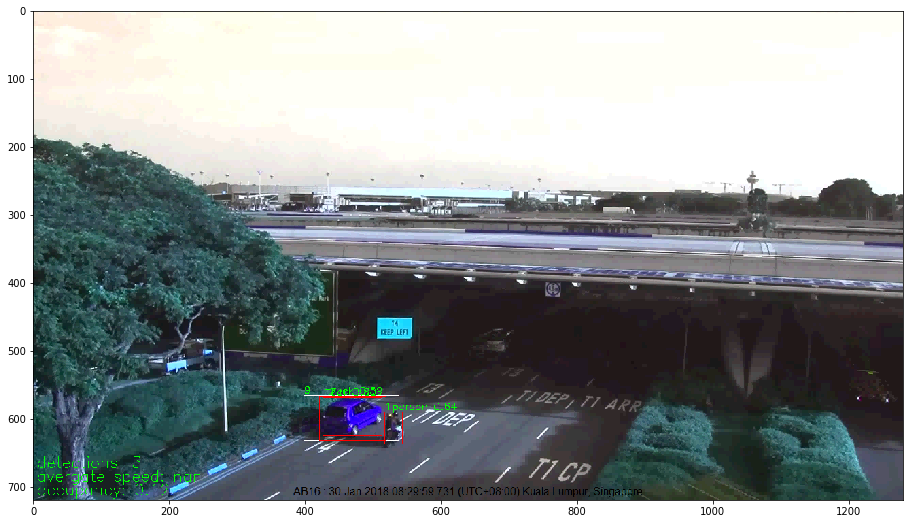

In [14]:
plt.figure(figsize=(16, 9))
plt.imshow(frame)

In [23]:
cv.imwrite('./CAG/test/AB16.jpg', frame)

True

array([ 0,  8, 16, 25])